## **Digitization of Handwritten Text**


IAM Handwriting Dataset is a collection of handwritten passages by serval writers. Generally, they use that data to classify writers according to their writing styles. A traditional way to solving such a problem is extracting features like spacing between letters, curvatures, etc. and feeding them into  support Vector Machines. But I wanted to solve this problem by Deep Learning using Keras and TensorFlow. For the purpose, we don’t need the Full IAM Handwriting Dataset, but some authentic subset which can be used for training such as a subset of images by top 50 persons who contributed the most towards the dataset.

In [1]:
# Enabling the Tensorflow 2.x version
%tensorflow_version 2.x

# Importing the tensorflow library
import tensorflow as tf

#prints the tensorflow version
print(tf.__version__)

2.2.0


In [2]:
# Importing the library to access the Google drive
from google.colab import drive

# Mount the google drive files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# locating the file IAM Handwritten zip in the google drive
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/Project_Code/Data/iam-handwriting-top50.zip

'/content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/iam-handwriting-top50.zip'


In [4]:
# we are unzipping the IAM Handwritten zip file
!unzip "/content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/iam-handwriting-top50.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/iam-handwriting-top50.zip
   creating: iam-handwriting-top50/data_subset/
   creating: iam-handwriting-top50/data_subset/data_subset/
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-00.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-01.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-02.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s00-03.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-00.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-01.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-02.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-000u-s01-03.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-003u-s00-00.png  
  inflating: iam-handwriting-top50/data_subset/data_subset/a01-003u-

In [5]:
dict_val = {}

with open('iam-handwriting-top50/forms_for_parsing.txt') as file:

  for line in file:

    key = line.split(' ')[0]
    writer = line.split(' ')[1]
    dict_val[key] = writer

print("Length of dict val:", len(dict_val.keys()))

Length of dict val: 1539


In [6]:
# Importing the libraies
import os
import glob
import numpy as np

# creating the empty list variables
temp = []
target_values = []

# accessing the image folder using os - it used to interface with the system to process releated function
image_loc = os.path.join('iam-handwriting-top50/data_subset/data_subset/', '*')

# glob - used to find all the path names matching a specific pattern
for file_name in sorted(glob.glob(image_loc)):

  # appending all the file_name into temp variable
  temp.append(file_name)

  image_name = file_name.split('/')[-1]

  file, extn = os.path.splitext(image_name)

  parts = file.split('-')

  form = parts[0] + '-' + parts[1]

  for key in dict_val:

    if key == form:

      # appending to target_values list
      target_values.append(str(dict_val[form]))

image_files = np.asarray(temp)
image_targets = np.asarray(target_values)

print("Shape of Image Files: ", image_files.shape)
print("Shape of Image Targets: ", image_targets.shape)

Shape of Image Files:  (4899,)
Shape of Image Targets:  (4899,)


## **Reading the Image**

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(image_targets)

encoder_Y = encoder.transform(image_targets)

In [8]:
from sklearn.model_selection import train_test_split

train_files, rem_files, train_targets, rem_targets = train_test_split(image_files, encoder_Y, train_size= 0.66, random_state= 52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(rem_files, rem_targets, train_size= 0.5, random_state= 22, shuffle= True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)


(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [9]:
#from sklearn.utils import shuffle
from PIL import Image
from __future__ import division
from random import *
from keras.utils import to_categorical


batchSize = 16
numClass = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, targetFiles, batchSize=batchSize, factor= 0.1):

  numSample = len(samples)
  from sklearn.utils import shuffle
  
  # Loop forever so the generator never terminates
  while 1:

    for offset in range(0, numSample, batchSize):

      batchSamples = samples[offset:offset+batchSize]
      batchTargets = targetFiles[offset:offset+batchSize]

      images = []
      targets = []

      for i in range(len(batchSamples)):

        batchSample = batchSamples[i]
        batchTarget = batchTargets[i]

        img = Image.open(batchSample)
        curWidth = img.size[0]
        curHeight = img.size[1]

        heightFac = 113 / curHeight

        newWidth = int(curWidth * heightFac)
        size = newWidth, 113

        # Resize so height = 113 while keeping aspect ratio
        imgresize = img.resize((size), Image.ANTIALIAS)
        nowWidth = imgresize.size[0]
        nowHeight = imgresize.size[1]

        # Generate crops of size 113*113 from this resized image and keep random 10% of crops
        
        # total x start points are from 0 to width - 113
        availXPoints = list(range(0, nowWidth - 113))

        # pick random x%
        pickNum = int(len(availXPoints)*factor)

        # Now pick
        randomStartx = sample(availXPoints, pickNum)

        for start in randomStartx:

          imgCrop = imgresize.crop((start, 0, start+113, 113))
          images.append(np.asarray(imgCrop))
          targets.append(batchTarget)

      # trim image to only see section with road
      X_train = np.array(images)
      y_train = np.array(targets)

      # reshape X_train for feeding in later
      X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)

      # convert to float and normalize
      X_train = X_train.astype('float32')
      X_train /= 255

      # One hot encode Y
      y_train = to_categorical(y_train, numClass)
      yield shuffle(X_train, y_train)


Using TensorFlow backend.


In [0]:
trainGenerator = generate_data(train_files, train_targets, batchSize, 0.3)

validationGenerator = generate_data(validation_files, validation_targets, batchSize, 0.3)

testGenerator = generate_data(test_files, test_targets, batchSize, 0.1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

def resize_image(image):

  return tf.image.resize(image, [56, 56])



In [12]:
# function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential([
                    ZeroPadding2D((1, 1), input_shape= (row, col, ch)),
                    Lambda(resize_image),
                    Convolution2D(filters= 32, kernel_size= (5, 5), strides= (2, 2), padding= 'SAME', name= 'Conv1'),
                    Activation('relu'),
                    MaxPooling2D(pool_size= (2, 2), strides= (2, 2), name= 'Pool1'),
                    Convolution2D(filters= 64, kernel_size= (3, 3), strides= (1, 1), padding= 'SAME', name= 'Conv2'),
                    Activation('relu'),
                    MaxPooling2D(pool_size= (2, 2), strides= (2, 2), name= 'Pool2'),
                    Convolution2D(filters= 128, kernel_size= (3, 3), strides= (1, 1), padding= 'SAME', name= 'Conv3'),
                    Activation('relu'),
                    MaxPooling2D(pool_size= (2, 2), strides= (2, 2), name= 'Pool3'),
                    Flatten(),
                    Dropout(0.5),
                    Dense(512, name= 'Dense1'),
                    Activation('relu'),
                    Dropout(0.5),
                    Dense(256, name= 'Dense2'),
                    Activation('relu'),
                    Dropout(0.5),
                    Dense(numClass, name= 'Output'),
                    Activation('softmax')
                  ])

model.compile(loss= 'categorical_crossentropy', optimizer= 'rmsprop', metrics= ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)       

In [0]:
from keras.callbacks import ModelCheckpoint

nb_epoch = 10
samplesPerEpoch = 1000
nbValSamples = 842

filePath = '/content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/checkpoints/check-{epoch:03d}.hdf5'

checkpoint = ModelCheckpoint(filepath= filePath, verbose= 1, save_best_only= True)

callback_list = [checkpoint]


In [14]:
step_el = nbValSamples / batchSize

history = model.fit_generator(trainGenerator, steps_per_epoch= samplesPerEpoch, validation_data= validationGenerator, validation_steps= nbValSamples, epochs= nb_epoch, verbose= 1, callbacks= callback_list)



Epoch 1/10
1000/1000 [==============================] - 933s 933ms/step - loss: 2.6537 - accuracy: 0.3038 - val_loss: 1.9772 - val_accuracy: 0.5097

Epoch 00001: val_loss improved from inf to 1.97718, saving model to /content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/checkpoints/check-001.hdf5
Epoch 2/10
1000/1000 [==============================] - 894s 894ms/step - loss: 1.5998 - accuracy: 0.5239 - val_loss: 0.8340 - val_accuracy: 0.6677

Epoch 00002: val_loss improved from 1.97718 to 0.83396, saving model to /content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/checkpoints/check-002.hdf5
Epoch 3/10
1000/1000 [==============================] - 904s 904ms/step - loss: 1.1793 - accuracy: 0.6443 - val_loss: 0.8411 - val_accuracy: 0.7432

Epoch 00003: val_loss did not improve from 0.83396
Epoch 4/10
1000/1000 [==============================] - 906s 906ms/step - loss: 0.9671 - accuracy: 0.7094 - val_loss: 0.3740 - val_accuracy: 0.7568

Epoch 00004: val_loss improved from 0.833

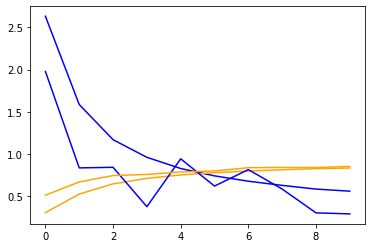

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], color='blue', label='Train Loss')
plt.plot(history.history["accuracy"], color='orange', label='Train Accuracy')
plt.plot(history.history["val_loss"], color='blue', label='Validation Loss')
plt.plot(history.history["val_accuracy"], color='orange', label='Validation Accuracy')

plt.show()

In [16]:
print("Train Loss: ", history.history["loss"][-1])
print("Train Accuracy: ", history.history["accuracy"][-1])

model.load_weights('/content/gdrive/My Drive/Colab Notebooks/Project_Code/Data/checkpoints/check-010.hdf5')

scores = model.evaluate_generator(testGenerator, 842)

print("Test Loss = ", scores[0])
print("Test Accuracy = ", scores[1])

Train Loss:  0.5579502352123564
Train Accuracy:  0.83277357
Test Loss =  0.4587275981903076
Test Accuracy =  0.8530997037887573


In [0]:
loss_data = [history.history["loss"][-1], scores[0]]
accuracy_data = [history.history["accuracy"][-1], scores[1]]

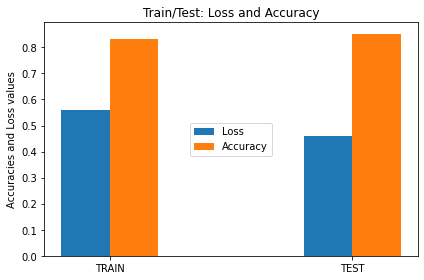

In [24]:
import warnings

warnings.filterwarnings('ignore')

model_name = ['TRAIN', 'TEST']

# comparing the Train and Test on Loss and Accuracy

x = np.arange(len(model_name))

width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, loss_data, width, label= "Loss")
rects2 = ax.bar(x + width/2, accuracy_data, width, label= "Accuracy")

ax.set_ylabel('Accuracies and Loss values')
ax.set_title('Train/Test: Loss and Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(model_name)
ax.legend(loc = 'center')
fig.tight_layout()

plt.show()


In [0]:
import matplotlib.pyplot as plt
import numpy as np
Training = [0.55,0.43]
Testing = [0.83,0.84]
models = ["TRAIN", "TEST"]
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Training, width, label="Loss")
rects2 = ax.bar(x + width/2, Testing, width, label='Accuracy')
ax.set_ylabel('Accuracies and loss values')
ax.set_title('Train/Test: Loss and Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc = 'center')
fig.tight_layout()

plt.show()